# Generate mitgcm input data A6
Note: Endianness of the binary files written here is not explicitly set and will depend on the machine you are working on. Use [numpy.dtype.newbyteorder](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.newbyteorder.html) to explicitly set the endianness or compile mitgcm such that the machine default will be used.

In [10]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import gsw
import xarray as xr
import ocean_tools.utils as utils


# It seems like float64 is the 
# default data type in numpy, but let's be 
# clear about this and write a little 
# test/conversion function.
def CheckFloat64(x):
    if x.dtype == np.float64:
        print('its a float64')
    else:
        print('converting to float64')
        x = x.astype(np.float64)
    return x

if not os.path.exists('fig/'):
    os.mkdir('fig/')
    
# Basic geometry for this case is 100 vertical 
# levels and 4*750 horizontal levels, running 
# on 8 cores.
nx = 1
ny = 3000
nz = 130

## Horizontal resolution

In [5]:
a = np.linspace(1000, 50, 500, dtype=np.float64)
b = np.squeeze(np.ones((1, 2000), dtype=np.float64))*20
c = np.linspace(50, 1000, 500, dtype=np.float64)

dy = np.hstack((a,b,c))
# unlike Matlab cumsum np.cumsum preserves input shape
y  = np.cumsum(dy)
y  = y - y[700]

# make sure dy is a float64
dy = CheckFloat64(dy)
# save to binary file
with open("delYvar", 'wb') as f:
    dy.tofile(f)

its a float64


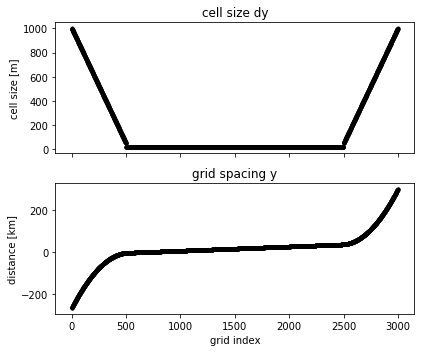

In [6]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,5))
ax[0].plot(dy, 'k.')
ax[0].set_title('cell size dy')
ax[0].set_ylabel('cell size [m]')

ax[1].plot(y/1000, 'k.')
ax[1].set_title('grid spacing y')
ax[1].set_ylabel('distance [km]')
ax[1].set_xlabel('grid index')

plt.tight_layout()
plt.savefig('fig/dy_and_y.pdf')

## Vertical resolution

In [34]:
# from bottom up - start out with 20m resolution here
dz1 = np.ones(60)*20
rema = 5300 - np.sum(dz1)
xx = np.arange(1,71,1)+20
dz2 = xx*rema/np.sum(xx)
dz = np.hstack((dz1, dz2))
dz = np.flipud(dz)
z = np.cumsum(dz)
# make sure dz is in float64
dz = CheckFloat64(dz)
# save to binary file
with open("delZvar", 'wb') as f:
    dz.tofile(f)

its a float64


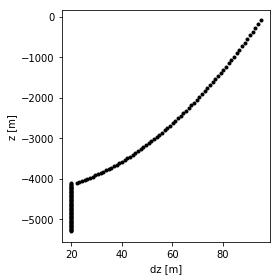

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(dz, -z, 'k.')
ax.set_ylabel('z [m]')
ax.set_xlabel('dz [m]')
plt.tight_layout()
plt.savefig('fig/dz.pdf')

## Bottom topography

In [9]:
tmp = utils.loadmat('track_towyo104_long.mat')
track = tmp['track']
del tmp

In [10]:
from scipy.interpolate import interp1d
x = track['dist']
depth = -track['depth']
f = interp1d(x*1000, depth, bounds_error=False)
d2 = f(y)
d2[0:504] = -5082
d2[2524:] = d2[2524]

# make sure it's float64
d2 = CheckFloat64(d2)
# save to binary
with open("topogSamoa.bin", 'wb') as f:
    d2.tofile(f)

its a float64


NameError: name 'gv' is not defined

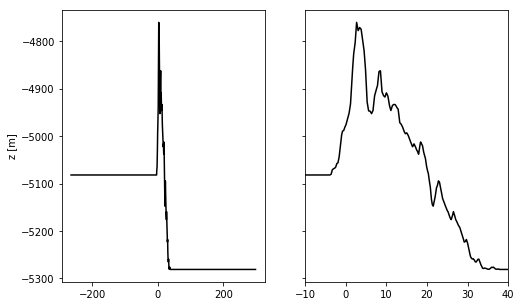

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)

ax[0].plot(y/1000,d2,'k')
ax[0].set_ylabel('z [m]')

ax[1].plot(y/1000, d2,'k');
ax[1].set(xlim=(-10,40))
for axi in ax:
    axi.set_xlabel('y [km]')
plt.savefig('fig/topo.pdf')

Adjust upstream botton depth to go to the same level as downstream.

In [12]:
y[504]/1e3

-3.92

In [13]:
y[206]/1e3

-100.11108216432861

In [14]:
from scipy.interpolate import interp1d
f = interp1d(y[[206, 504]], [d2[2524], d2[505]])

In [15]:
test = f(y[206:505])

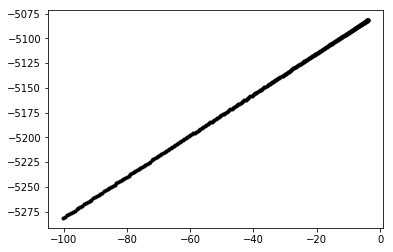

In [16]:
plt.plot(y[206:505]/1000, test, 'k.')

In [17]:
d2old = d2.copy()
d2[206:505] = test
d2[0:206] = test[0]

In [18]:
# make sure it's float64
d2 = CheckFloat64(d2)
# save to binary
with open("topogSamoa.bin", 'wb') as f:
    d2.tofile(f)

its a float64


NameError: name 'gv' is not defined

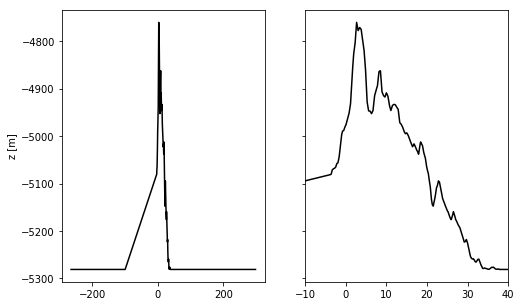

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)

ax[0].plot(y/1000,d2,'k')
ax[0].set_ylabel('z [m]')

ax[1].plot(y/1000, d2,'k');
ax[1].set(xlim=(-10,40))
for axi in ax:
    axi.set_xlabel('y [km]')
plt.savefig('fig/topo.pdf')

Make sure the flat bottom connects nicely to the real bathymetry

NameError: name 'gv' is not defined

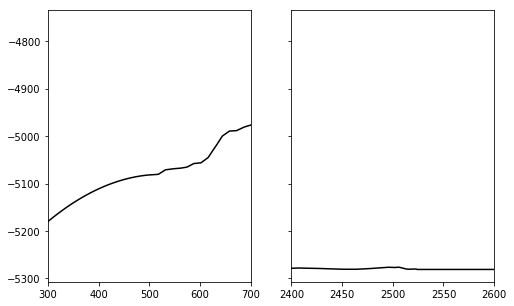

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5), sharey=True)
ax[0].plot(d2,'k');
ax[0].set(xlim=(300, 700))
ax[1].plot(d2,'k');
ax[1].set(xlim=(2400, 2600))


See how steppy the topography is at 20m vertical resolution (although I realize this doesn't make sense to look at since there are partially filled bottom cells).

In [21]:
xx = d2.copy()
bins = -z
inds = np.digitize(xx, bins)
d2d = -z[inds]

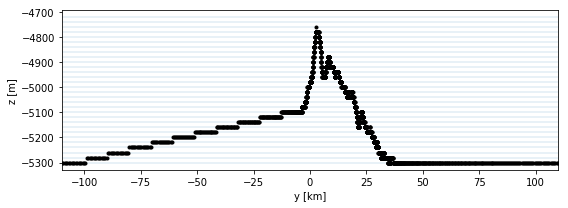

In [22]:
fig, ax = plt.subplots(figsize=(8,3))
[ax.axhline(y=yy, linewidth=0.2) for yy in np.arange(-5300,-4700,20)]
ax.plot(y/1000, d2d, 'k.')
ax.set_ylabel('z [m]')
ax.set_xlabel('y [km]')
ax.set_xlim([-110,110])
plt.tight_layout()
plt.savefig('fig/topo_resolution.pdf')

Find grid point of sill crest for stratification interpolation further below.

In [23]:
d2i = np.argmax(d2)
print(d2i)
print(d2[d2i])

832
-4759.749453354152


## Stratification
Using a linear equation of state with $\alpha_T=2\times10^{-4}$.

In [23]:
gravity = 9.81;
talpha = 2.0e-4;

Upstream station 9-14, downstream 9-18

In [24]:
tmp = utils.loadmat('CTD0914.mat')
ctd1 = tmp['CTD']
del tmp

tmp = utils.loadmat('CTD0918.mat')
ctd2 = tmp['CTD']
del tmp

In [25]:
ctd1.keys()

dict_keys(['section', 'station', 'stationstr', 'cast', 'lon', 'lat', 'timevec', 'time', 'timestr', 'z', 'p', 't1', 't2', 'theta1', 'theta2', 's1', 's2', 'sigma1', 'sigma2', 'sigma41', 'sigma42', 'oxygen', 'u', 'v'])

Load a few more ctd profiles

In [26]:
c = xr.open_dataset('sp12_ctd.nc')

In [27]:
c

<xarray.Dataset>
Dimensions:  (i: 109, z: 6001)
Coordinates:
  * z        (z) uint16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    p        (i, z) float64 ...
    sec      (i) int64 ...
    time     (i) datetime64[ns] ...
    station  (i) int64 ...
    cast     (i) int64 ...
    lon      (i) float64 ...
    lat      (i) float64 ...
Dimensions without coordinates: i
Data variables:
    th       (z, i) float64 ...
    s        (z, i) float64 ...
    t        (z, i) float64 ...

In [28]:
sec9 = c.where(c.sec==9, drop=True)

In [29]:
b = gv.ocean.smith_sandwell(c.lon, c.lat)
b.plot(cmap='Blues_r')
plt.plot(sec9.lon, sec9.lat, 'ko')
tmp1 = sec9.th.where(sec9.station==12, drop=True)
tmp2 = sec9.th.where(sec9.station==19, drop=True)

plt.plot(tmp1.lon, tmp1.lat, 'ro')
plt.plot(tmp2.lon, tmp2.lat, 'yo')

NameError: name 'gv' is not defined

In [30]:
sec9.station

<xarray.DataArray 'station' (i: 22)>
array([  1,   2,   3,   4,   5,   6,   7,   8,   9, 102, 101, 111, 112,  12,
        13,  14,  15,  16, 171,  18, 172,  19])
Coordinates:
    sec      (i) int64 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
    time     (i) datetime64[ns] 2012-08-02T14:04:00 2012-08-02T19:45:00 ...
    station  (i) int64 1 2 3 4 5 6 7 8 9 102 101 111 112 12 13 14 15 16 171 ...
    cast     (i) int64 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 ...
    lon      (i) float64 -169.6 -169.3 -169.1 -169.0 -169.0 -169.0 -169.0 ...
    lat      (i) float64 -9.979 -9.829 -9.655 -9.48 -9.305 -9.141 -9.041 ...
Dimensions without coordinates: i

ok, let's use stations 12 and 19 instead of 14 and 18 for a little more potential energy.

[(5000, 3500), (0.67, 1.25)]

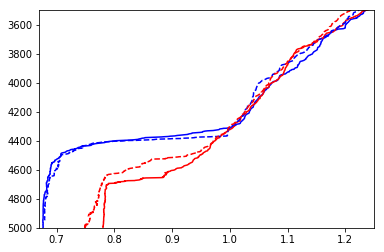

In [31]:
tmp = sec9.th.where(sec9.station==12, drop=True)
plt.plot(tmp, tmp.z, 'b')
tmp = sec9.th.where(sec9.station==19, drop=True)
plt.plot(tmp, tmp.z, 'r')

plt.plot(ctd1['theta1'], ctd1['z'],'b--')
plt.plot(ctd2['theta1'], ctd2['z'],'r--')
plt.gca().set(ylim=(5000, 3500), xlim=(0.67,1.25))

Calculate N$^2$ from the CTD data, smooth it and then translate it to the linear equation of state.
$$
N^2 = -\frac{g}{\rho} \frac{d \rho}{dz}
$$
$$
\rho = \alpha_T \theta
$$
$$
T_{z0} = \frac{N^2}{g \alpha_T}
$$

In [36]:
tmp = sec9.where(sec9.station==12, drop=True)
SA = gsw.SA_from_SP(tmp.s.squeeze(), tmp.p.squeeze(), tmp.lon, tmp.lat)
CT = gsw.CT_from_t(SA, tmp.t.squeeze(), tmp.p.squeeze())
N2, pmid = gsw.Nsquared(SA, CT, tmp.p.squeeze(), tmp.lat)
ctdz = tmp.z[1:]
good = np.where(~np.isnan(tmp.t.squeeze()))
from scipy.signal import convolve2d
# convolve2d wants 2D arrays
N2smooth = convolve2d(np.reshape(N2[good],(len(N2[good]),1)), np.reshape(np.ones(100)/100,(100,1)), mode='same')
# back to 1D array
N2smooth = np.squeeze(N2smooth)
f = sp.interpolate.interp1d(ctdz[good], N2smooth, bounds_error=False)
N2 = f(z)
# translate N2 to the linear equation of state
tz0 = N2/(gravity*talpha)
# integrate vertically
t = np.cumsum(-tz0*dz)
TrefS = t-t[0]+18.353
# replace bottom nan's with deepest value
ind = np.where(~np.isnan(TrefS))[0]
first, last = ind[0], ind[-1]
TrefS[last + 1:] = TrefS[last]
NrefS = N2

In [38]:
tmp = sec9.where(sec9.station==19, drop=True)
SA = gsw.SA_from_SP(tmp.s.squeeze(), tmp.p.squeeze(), tmp.lon, tmp.lat)
CT = gsw.CT_from_t(SA, tmp.t.squeeze(), tmp.p.squeeze())
N2, pmid = gsw.Nsquared(SA, CT, tmp.p.squeeze(), tmp.lat)
ctdz = tmp.z[1:]
good = np.where(~np.isnan(tmp.t.squeeze()))
from scipy.signal import convolve2d
# convolve2d wants 2D arrays
N2smooth = convolve2d(np.reshape(N2[good],(len(N2[good]),1)), np.reshape(np.ones(100)/100,(100,1)), mode='same')
# back to 1D array
N2smooth = np.squeeze(N2smooth)
f = sp.interpolate.interp1d(ctdz[good], N2smooth, bounds_error=False)
N2 = f(z)
# translate N2 to the linear equation of state
tz0 = N2/(gravity*talpha)
# integrate vertically
t = np.cumsum(-tz0*dz)
TrefN = t-t[0]+19.294
# replace bottom nan's with deepest value
ind = np.where(~np.isnan(TrefN))[0]
first, last = ind[0], ind[-1]
TrefN[last + 1:] = TrefN[last]
NrefN = N2

[(1000, 0), (2, 20)]

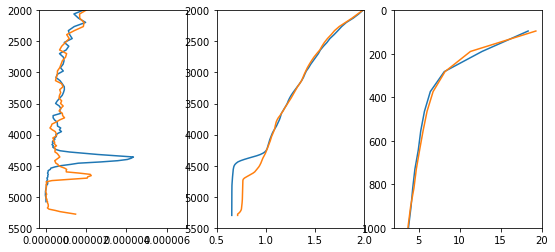

In [39]:
fig, ax = plt.subplots(1,3, figsize=(9,4))
ax[0].plot(NrefS,z)
ax[0].plot(NrefN,z)
ax[0].set(ylim=(5500,2000), xlim=(-3e-7,7e-6))

ax[1].plot(TrefS,z)
ax[1].plot(TrefN,z)
ax[1].set(ylim=(5500,2000), xlim=(0.5, 2))

ax[2].plot(TrefS,z)
ax[2].plot(TrefN,z)
ax[2].set(ylim=(1000, 0), xlim=(2, 20))

In [40]:
tmp = sec9.where(sec9.station==12, drop=True)
print(tmp.th.min())
# print(np.nanmin(ctd1['theta1']))
print(np.nanmin(TrefS))

<xarray.DataArray 'th' ()>
array(0.675398)
0.653159388941333


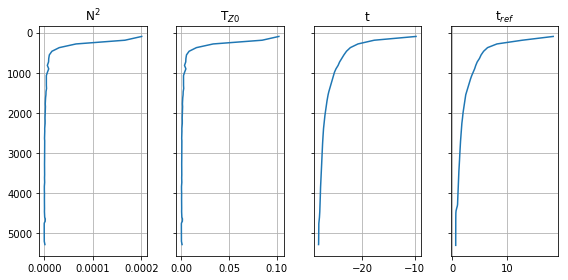

In [41]:
fig, ax = plt.subplots(1,4,sharey=True, figsize=(8,4))
ax[0].plot(N2,z)
ax[0].set_title('N$^2$')
ax[1].plot(tz0,z)
ax[1].set_title('T$_{Z0}$')
ax[2].plot(t,z)
ax[2].set_title('t')
ax[3].plot(TrefS,z)
ax[3].set_title('t$_{ref}$')
ax[0].invert_yaxis()
for axi in ax:
    axi.grid()
plt.tight_layout()
plt.savefig('fig/n2-tref.pdf')

Convert this into a function to easily generate two profiles at once

In [42]:
def GenerateTref(ctd):
    SA = gsw.SA_from_SP(ctd.s.squeeze(), ctd.p.squeeze(), ctd.lon, ctd.lat)
    CT = gsw.CT_from_t(SA, ctd.t.squeeze(), ctd.p)
    N2, pmid = gsw.Nsquared(SA, CT, ctd.p.squeeze(), ctd.lat)
    ctdz = ctd.z[1:]
    good = np.where(~np.isnan(ctd.t.squeeze()))
    from scipy.signal import convolve2d
    # convolve2d wants 2D arrays
    N2smooth = convolve2d(np.reshape(N2[good],(len(N2[good]),1)), np.reshape(np.ones(100)/100,(100,1)), mode='same')
    # back to 1D array
    N2smooth = np.squeeze(N2smooth)
    f = interp1d(ctdz[good], N2smooth, bounds_error=False)
    N2 = f(z)
    # translate N2 to the linear equation of state
    tz0 = N2/(gravity*talpha)
    # integrate vertically
    t = np.cumsum(-tz0*dz)
    Tref = t-t[0]+18.8094
    # replace bottom nan's with deepest value
    ind = np.where(~np.isnan(Tref))[0]
    first, last = ind[0], ind[-1]
    Tref[last + 1:] = Tref[last]
    return Tref

(0.5, 1.5)

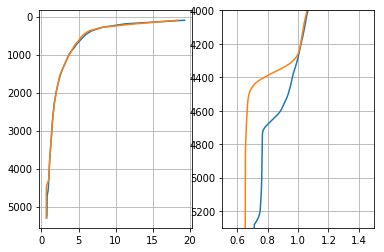

In [43]:
fig, ax = plt.subplots(1,2)
ax[0].plot(TrefN,z)
ax[0].plot(TrefS,z)
ax[0].invert_yaxis()
ax[0].grid()

ax[1].plot(TrefN,z)
ax[1].plot(TrefS,z)
ax[1].invert_yaxis()
ax[1].grid()
ax[1].set_ylim(5300,4000)
ax[1].set_xlim(0.5,1.5)

Make the profiles the same in the upper layer

In [44]:
TrefN[z<4200] = TrefS[z<4200]

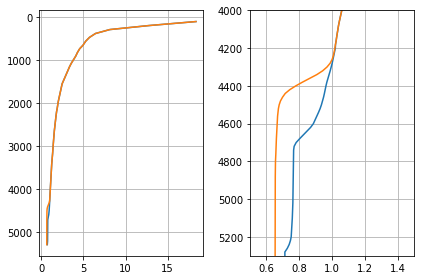

In [45]:
fig, ax = plt.subplots(1,2)
ax[0].plot(TrefN,z)
ax[0].plot(TrefS,z)
ax[0].invert_yaxis()
ax[0].grid()

ax[1].plot(TrefN,z)
ax[1].plot(TrefS,z)
ax[1].invert_yaxis()
ax[1].grid()
ax[1].set_ylim(5300,4000)
ax[1].set_xlim(0.5,1.5)

plt.tight_layout()
plt.savefig('fig/tref-profiles.pdf')

Save profiles for open boundary conditions

In [48]:
# if we use cyclic forcing of the velocity then presumably
# these must also be specified in time too!
TrefN = np.tile(TrefN[np.newaxis, :, np.newaxis], (12, 1, nx))
TrefS = np.tile(TrefS[np.newaxis, :, np.newaxis], (12, 1, nx))

TrefN = CheckFloat64(TrefN)
# save to binary
with open("OB_North_T.bin", 'wb') as f:
    TrefN.tofile(f)
TrefS = CheckFloat64(TrefS)
# save to binary
with open("OB_South_T.bin", 'wb') as f:
    TrefS.tofile(f)

its a float64
its a float64


also save the southern profile as reference profile

In [43]:
with open("Tref", 'wb') as f:
    TrefS.tofile(f)

In [44]:
TrefN.shape

(130,)

# Generate inital stratification

In [45]:
T = np.zeros((nz, ny))
for i, (ts, tn) in enumerate(zip(TrefS, TrefN)):
    # d2i is the index at the ridge crest
    f = interp1d(y[[0, d2i, 2600, 2999]], [ts, ts, tn, tn], bounds_error=False)
    T[i,:] = f(y)

# convert to 3D array (not sure if needed for 2D field, but nice to have for future cases)
# Tinit = np.zeros([nx,ny,nz])
# for k in np.arange(0,nx):
#     Tinit[k,:,:] = np.transpose(T[:,0:ny])

# this seems to work (not sure why it has to be nx, nz, ny)
Tinit2 = np.zeros([nx,nz,ny])
for k in np.arange(0,nx):
    Tinit2[k,:,:] = T[:,0:ny]

# Tinit = CheckFloat64(Tinit)
# # save to binary
# with open("T.init", 'wb') as f:
#     Tinit.tofile(f)
    
Tinit2 = CheckFloat64(Tinit2)
# save to binary
with open("T.init", 'wb') as f:
    Tinit2.tofile(f)

its a float64


In [46]:
Tinit2.shape

(1, 130, 3000)

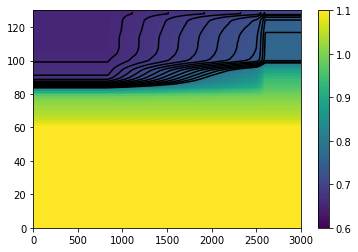

In [47]:
fig, ax = plt.subplots()
h = ax.pcolormesh(Tinit2[0,:,:], vmin=0.6, vmax=1.1)
ax.contour(Tinit2[0,:,:], levels=np.arange(0.6,0.79,0.01), colors='k')
plt.colorbar(h)

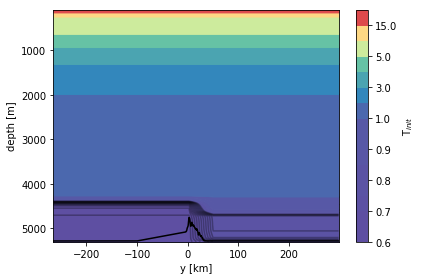

In [48]:
fig, ax = plt.subplots()
cs = plt.contourf(y/1000, z, np.ma.masked_invalid(T), levels=[0.6, 0.65,0.7,0.75,0.8,0.85,0.9,0.95,1,2,3,4,5,10,15,20], cmap='Spectral_r')
for c in cs.collections:
    c.set_edgecolor('face')
plt.contour(y/1000, z, np.ma.masked_invalid(T), levels=np.arange(0.6,0.8,0.01), colors='k', alpha=0.3)
plt.gca().invert_yaxis()
plt.colorbar(cs, label='T$_{init}$')
plt.plot(y/1000, -d2, 'k');
plt.xlabel('y [km]')
plt.ylabel('depth [m]')
plt.tight_layout()
plt.savefig('fig/Tinit.pdf')

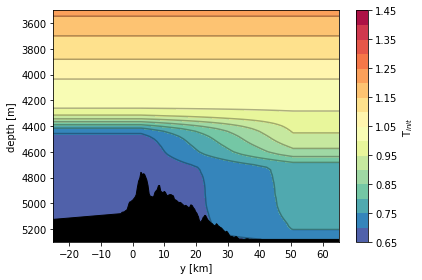

In [49]:
fig, ax = plt.subplots(1, 1)
cs = plt.contourf(y/1000, z, np.ma.masked_invalid(T),
                  levels=np.arange(0.65,1.5,0.05),
                  cmap='Spectral_r')
for c in cs.collections:
    c.set_edgecolor('face')
ax.contour(y/1000, z, np.ma.masked_invalid(T), levels=np.arange(0.6,1.5,0.05), colors='k', alpha=0.3)
ax.invert_yaxis()
plt.colorbar(cs, label='T$_{init}$')
ax.fill_between(y/1000, np.abs(d2), np.ones_like(d2)*1e4, color='k');
ax.set(xlabel='y [km]', ylabel='depth [m]', xlim=(-25, 65), ylim=(5300, 3500))
ax.grid(False)
plt.tight_layout()
plt.savefig('fig/Tinit_zoom.pdf')

Generate tidal boundary conditions
--------------------------------

M2 tidal period is 12.4 hours roughly. 

In [51]:
# Forcing for boundaries
v0 = 0.03  # barotropic tidal speed m/s
M2period = 12.4  # hours
dt = 3720.  # forcing specified every dt seconds
time = np.arange(0, 12.*dt, dt) 
om = 2*np.pi/(M2period*3600)  # M2 period changed to seconds here
vs = v0*np.sin(om*time)  # Southern boundary tide
vn = v0*np.sin(om*time)  # Northern boundary tide


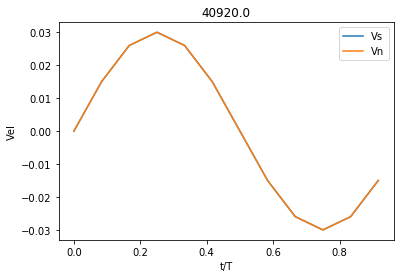

In [52]:
plt.figure()
plt.plot(time/3600./12.4, vs, label='Vs')
plt.plot(time/3600./12.4, vn, label='Vn')
plt.legend()
plt.xlabel('t/T')
plt.ylabel('Vel')
plt.title('{}'.format(time[-1]))
plt.savefig('fig/Vels.pdf')

In [53]:
# try time,nz,ny...
vsn = np.tile(vs[:, np.newaxis, np.newaxis], (1, nz, nx))
vnn = np.tile(vn[:, np.newaxis, np.newaxis], (1, nz, nx))

with open("Vs.bin", "wb") as f:
    vsn.tofile(f)

with open("Vn.bin", "wb") as f:
    vnn.tofile(f)
